# Машинное обучение
## ВМК МГУ, весна 2015/2016
## Лабораторная работа 1. Линейные модели

ФИО: Попов Артём Сергеевич

Группа: 317

Данное задание посвящено применению линейных моделей в задачах классификации и регрессии. Вы научитесь:
* делать one-hot-кодирование категориальных признаков
* обучать логистическую и линейную регрессию
* отбирать признаки с помощью LASSO
* вычислять метрики качества классификации и регрессии
* выбирать лучший классификатор при ограничениях на точность или полноту
* калибровать вероятности
* реализовывать градиентный спуск (если захотите)


In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

## Часть 1. Научные гранты в Австралии

![](http://imgur.com/cBdDBO3.jpg)

В данной части мы будем работать с задачей "Predict Grant Applications" (https://www.kaggle.com/c/unimelb/data), где для заявки на грант требуется предсказать, одобрят её или нет. Будем использовать лишь 40 признаков из имеющихся 249. Файлы для работы можно найти по ссылкам:
* https://db.tt/iYzRzQYP (обучение)
* https://db.tt/NGSHb5Qs (контроль)

#### Задание 1
Считайте обучающую и контрольную выборки из файлов с помощью pd.read_csv. Выделите целевую переменную (Grant.Status) в отдельный вектор.

In [3]:
data_train = pd.read_csv('data/unimel_train.csv')
data_test = pd.read_csv('data/unimel_test.csv')

In [4]:
y_train = data_train['Grant.Status']
y_test = data_test['Grant.Status']

data_train = data_train.drop(['Grant.Status'], axis=1)
data_test = data_test.drop(['Grant.Status'], axis=1)

#### Задание 2
В этом задании мы приведем данные к виду, пригодному для обучения линейных классификаторов. Для этого вещественные признаки надо отмасштабировать, а категориальные — привести к числовому виду. Также надо устранить пропуски в данных.

В первую очередь поймем, зачем здесь нужно масштабирование. Нарисуем распределение трех признаков.

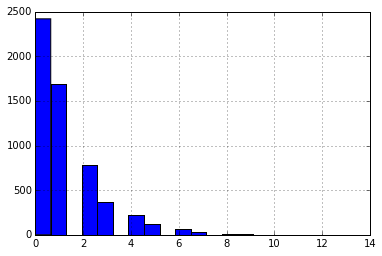

In [19]:
data_train['Number.of.Successful.Grant.1'].hist(bins=20)

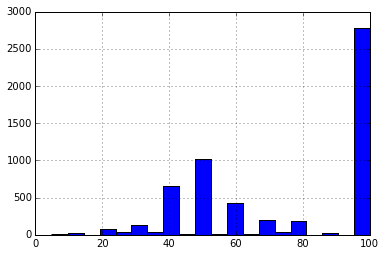

In [20]:
data_train['RFCD.Percentage.1'].hist(bins=20)

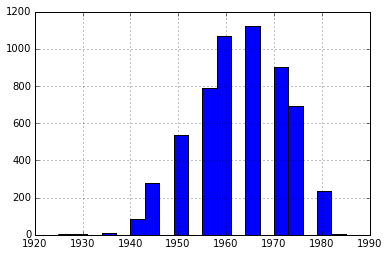

In [21]:
data_train['Year.of.Birth.1'].hist(bins=20)

Какую проблему вы наблюдаете на этих графиках? Как масштабирование поможет её исправить?

Признаки изменяются в разных диапазонах (это может ухудушить работу линейных методов). 
Масштабирование исправит эту проблему.

В наших данных есть пропуски. Ответьте на вопросы:

1 Сколько всего пропущенных элементов в таблице с обучающей выборкой?

In [33]:
np.sum(np.sum(data_train.isnull()))

26843

2  Сколько объектов имеют хотя бы один пропуск?

In [59]:
np.where(np.sum(data_train.isnull(), axis=1) > 0)[0].shape[0]

5879

3 Сколько признаков имеют хотя бы одно пропущенное значение?

In [61]:
np.where(np.sum(data_train.isnull(), axis=0) > 0)[0].shape[0]

38

Большинство признаков в нашем датасете являются категориальными. Типичным подходом к работе с ними является бинарное, или one-hot-кодирование (также есть подход со счётчиками, который мы уже применяли в прошлых работах). Для начала потренируемся делать бинарное кодирование на трех игрушечных объектах.

In [63]:
simple_data = pd.DataFrame({'City': ['Msk', 'SPb', 'Msk'], 'Weather': ['good', 'bad', 'worst']})
simple_data.head()

,City,Weather
0,Msk,good
1,SPb,bad
2,Msk,worst


In [64]:
# преобразуем каждый объект в dict
simple_data_dict = simple_data.T.to_dict().values()
print (simple_data_dict)

dict_values([{'City': 'Msk', 'Weather': 'good'}, {'City': 'SPb', 'Weather': 'bad'}, {'City': 'Msk', 'Weather': 'worst'}])


In [65]:
# делаем one-hot-кодирование
transformer = DictVectorizer(sparse=False)
# примените здесь DictVectorizer к simple_data_dict, получите бинарную матрицу и выведите её
print(transformer.fit_transform(simple_data_dict))

[[ 1.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.]
 [ 1.  0.  0.  0.  1.]]


Реализуйте функцию transform_data, которая принимает на вход DataFrame с признаками, объекты классов StandardScaler и DictVectorizer и булеву переменную is_test (True, если обрабатывает тестовую выборку и False, если обучающую). В функции должны выполняться следующие шаги:
1. Замена пропущенных значений на нули для вещественных признаков и на строки 'nan' для категориальных. Используйте для выполнения замены функцию fillna. Имена всех вещественных переменных перечислены в numeric_cols.
2. Масштабирование вещественных признаков с помощью StandardScaler (метод fit_transform, если is_test == False, и метод transform в противном случае).
3. One-hot-кодирование категориальных признаков с помощью DictVectorizer (метод fit_transform, если is_test == False, и метод transform в противном случае).

Метод должен возвращать tuple из трех элементов: преобразованной выборки, объекта StandardScaler и объекта DictVectorizer. Преобразованная выборка должна состоять из масштабированных вещественных признаков и закодированных категориальных (исходные признаки не должны в ней остаться).

In [8]:
def transform_data(data, scaler, transformer, is_test):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    categorial_cols = list(set(data.columns).difference(set(numeric_cols)))
    data[numeric_cols] = data[numeric_cols].fillna(0)
    data[categorial_cols] = data[categorial_cols].fillna('nan')
    data[categorial_cols] = data[categorial_cols].applymap(lambda x: str(x))
    
    if is_test:
        data[numeric_cols] = scaler.transform(data[numeric_cols])
        temp = pd.DataFrame(transformer.transform(data[categorial_cols].T.to_dict().values()))
        indexes = list(map(lambda x: str(x), range(temp.shape[1])))
        data[indexes] = temp
    else:
        data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
        temp = pd.DataFrame(transformer.fit_transform(data[categorial_cols].T.to_dict().values()))
        indexes = list(map(lambda x: str(x), range(temp.shape[1])))
        data[indexes] = temp
    
    return data.drop(categorial_cols, axis=1), scaler, transformer

Применяем функцию к данным:

In [9]:
scaler = StandardScaler()
transformer = DictVectorizer(sparse=False)
X, scaler, transformer = transform_data(data_train, scaler, transformer, False)
X_test, _, _ = transform_data(data_test, scaler, transformer, True)

Сколько признаков у вас получилось после преобразования?

In [8]:
print (X.shape[1])

11734


#### Задание 3
Подберите лучшее значение параметра регуляризации C для логистической регрессии с L2-регуляризатором (sklearn.linear_model.LogisticRegression) с помощью кросс-валидации по 5 блокам. В качестве метрики качества используйте AUC-ROC. Сетка для перебора 
ниже. По итогам кросс-валидации укажите лучшее значение параметра регуляризации. Обучите классификатор с этим параметром на всей обучающей выборке и найдите качество (AUC-ROC) на тестовой выборке.

In [10]:
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression(penalty='l2')

In [70]:
from sklearn.cross_validation import KFold
cv = KFold(X.shape[0], n_folds=5, shuffle=True, random_state=241)

In [11]:
from sklearn.cross_validation import cross_val_score

In [72]:
# вам пригодятся функции cross_val_score или GridSearchCV; используйте в них объект cv в качестве генератора разбиений
C_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

for C in C_grid:
    clf1.C = C
    print(np.mean(np.array(cross_val_score(clf1, X, y_train, cv=cv))))

0.755701394586
0.791796554553
0.80771123872
0.802625102543
0.791304347826
0.786710418376


In [31]:
from sklearn.metrics import roc_auc_score

In [74]:
clf1.C = 0.1
clf1.fit(X, y_train)
print(roc_auc_score(y_test, clf1.predict_proba(X_test)[:, 1]))

0.880346701167


Попробуем теперь логистическую регрессию с L1-регуляризатором (penalty='l1'). Выведите число ненулевых коэффициентов (clf.coef\_) при каждом значении параметра регуляризации из сетки.

In [75]:
clf1.penalty = 'l1'

for C in C_grid:
    clf1.C = C
    clf1.fit(X, y_train)
    print(np.sum(clf1.coef_ != 0))

0
9
58
667
2468
2857


Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01? Сколько для достижения такого качества ей нужно признаков?

In [76]:
clf1.C = 0.01
clf1.fit(X, y_train)
print(roc_auc_score(y_test, clf1.predict_proba(X_test)[:, 1]))

0.85254615488


Ненулевых значений признаков - 667

#### Задание 4
В этом задании мы внимательно рассмотрим различные аспекты качества классификатора. Для этого возьмите классификатор с L2-регуляризатором с лучшим значением параметра регуляризации (вы его нашли в предыдущем задании), обучите на полной обучающей выборке и найдите предсказания вероятностей на тесте. Далее будем работать только с этими прогнозами.

In [77]:
clf1.penalty = 'l2'
clf1.C = 0.1
clf1.fit(X, y_train)
y_pred = clf1.predict_proba(X_test)[:, 1]

Посчитайте AUC-ROC, AUC-PR (average_precision_score) и log-loss для прогнозов.

In [11]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss

In [79]:
print('AUC-ROC', roc_auc_score(y_test, y_pred))
print('AUC-PR', average_precision_score(y_test, y_pred))
print('log-loss', log_loss(y_test, y_pred))

AUC-ROC 0.880346701167
AUC-PR 0.8387555666
log-loss 0.442736820847


Нарисуйте ROC- и PR-кривые. Не забудьте подписать оси.

In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

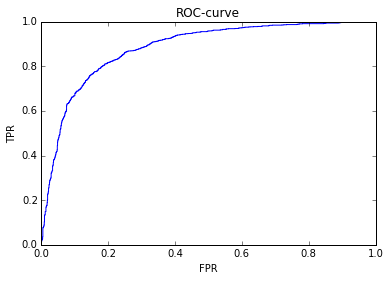

In [69]:
fpr, tpr, thresholds= roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-curve')

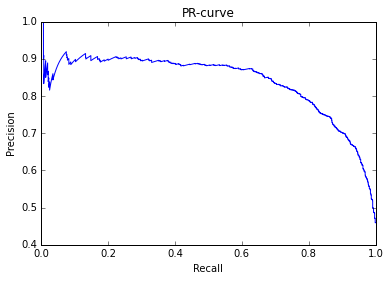

In [23]:
pr, rec, thresholds= precision_recall_curve(y_test, y_pred)
plt.plot(rec, pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-curve')

Допустим, мы хотим построить классификатор, который будет находить не менее 90% успешных грантов. Соответственно, имеем нижнюю границу 90% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога? Для получения ответа проанализируйте массивы, возвращаемые функцией metrics.precision_recall_curve.

In [30]:
max_pr = np.amax(pr[np.where(rec > 0.9)[0]])
ind = np.where(pr == max_pr)[0]

In [31]:
rec[ind], pr[ind]

(array([ 0.90008326]), array([ 0.70194805]))

Возьмите классификатор с порогом из предыдущего пункта и подсчитайте для него F-меру. Почему она получилась маленькой, несмотря на высокую полноту?

In [85]:
f_measure = 2 * (pr[ind] * rec[ind]) / (pr[ind] + rec[ind])
f_measure

0.78876322510032837

F-мера — среднее гармоническое от полноты и точности. Среднее гармоническое - величина, которая сильно зависит от обоих своих параметров. Так как один из параметров небольшой, то и значение F-меры не самое высокое.

Допустим, что университету важно подавать как можно меньше заявок, которые окажутся неуспешными — они очень плохо влияют на репутацию. Установим нижнюю границу на точность 80%. Какую максимальную полноту при этом можно обеспечить? При каком пороге?

In [36]:
max_rec = np.amax(rec[np.where(pr > 0.8)[0]])
ind = list(set(np.where(rec == max_rec)[0]).intersection(set(np.where(pr > 0.8)[0])))

print(max_rec)

0.776019983347


Возможные значения порогов:

In [37]:
thresholds[ind]

array([ 0.53010529,  0.53037779,  0.53125795,  0.53127795,  0.53181576,
        0.53194203])

#### Задание 5
В этом задании мы научимся оценивать способность классификатора предсказывать вероятности, а также разберемся с калибровкой.

Начнем с калибровочных кривых. Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [92]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        temp = y_test[(preds >= l) & (preds < r)]
        bin_real_ratios.append(np.sum(temp == 1) / temp.shape[0])
    plt.plot(bin_middle_points, bin_real_ratios)

Проверим её работу на логистической регрессии (поменяйте имена переменных, если это необходимо). Получилась ли почти диагональная калибровочная кривая?

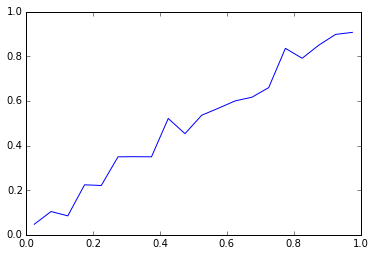

In [93]:
clf = LogisticRegression(C=1.0)
clf.fit(X, y_train)
preds = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

Да, получилась.

Заодно обратим внимание на то, как часто классификатор выдает те или иные вероятности.

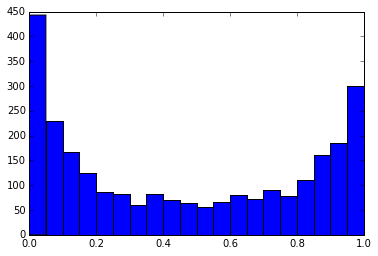

In [94]:
plt.hist(preds, bins=20)
plt.show()

Обучим теперь классификатор с кусочно-линейной функцией потерь (hinge loss, как в SVM).

In [111]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
clf.fit(X, y_train)
preds = clf.decision_function(X_test)
preds = 1.0 / (1.0 + np.exp(-preds))

Изучите распределение ответов классификатора. Чем оно отличается от распределения у логистической регрессии? Чем вы можете объяснить это?

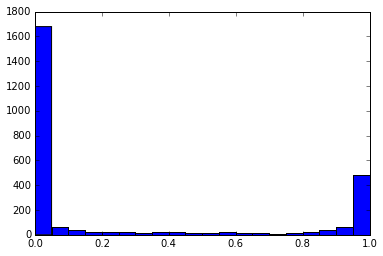

In [112]:
plt.hist(preds, bins=20)
plt.show()

Отличается тем, что распределение для логистической регрессии было более гладким. Распределение для кусочно-линейной функции потерь содержит два максимума (0 и 1) а во все остальные точки попало небольшое количество объектов.

Если посмотреть на графики функций потерь, то можно заметить, что функция потерь для лог. регрессии пытается улучшить качество классификации тогда, когда при hinge loss уже значение функции потерь равно нулю.

Нарисуем калибровочную кривую. Видите ли вы какие-либо проблемы в ней?

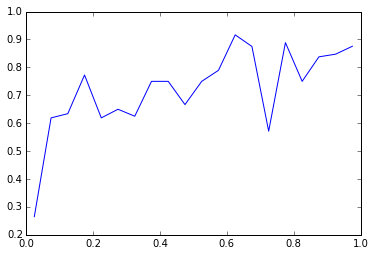

In [113]:
plot_calibration_curve(y_test, preds)

Не диагональна.

Попробуем откалибровать вероятности. Грубо говоря, это процедура, которая для каждого отрезка $[a_i, b_i]$ строит преобразование, которое корректирует вероятности в нем, приводя тем самым калибровочную кривую к диагональной форме.

Воспользуйтесь классом sklearn.calibration.CalibratedClassifierCV для калибровки вероятностей на обучении, и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [118]:
from sklearn.calibration import CalibratedClassifierCV

In [121]:
clf1 = CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge'))
clf1.fit(X, y_train)
preds = clf1.predict_proba(X_test)

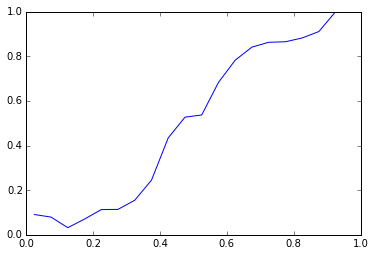

In [132]:
plot_calibration_curve(y_test, preds[:, 1])

Да, улучшилась

#### Задание 6
Здесь вы можете вставить вашу любимую картинку про Австралию.

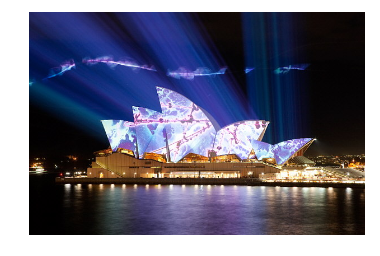

In [56]:
image = plt.imread('data/sydney_opera_house.jpg')
plt.axis('off')
plt.imshow(image)


## Часть 2. Градиентный спуск своими руками
**(опциональная часть, за правильное выполнение к оценке добавляется 3 балла)**

В этой части вам предстоит самостоятельно реализовать градиентный спуск для логистической функции потерь — то есть, по сути, собственными руками обучить логистическую регрессию. Будем использовать данные из предыдущей части.

Добавьте к обучающей и тестовой выборкам единичный признак. Переведите значения целевого вектора в множество $\{-1, +1\}$.

In [12]:
X['singular'] = 1
X_test['singular'] = 1
y_train = (y_train - 0.5) * 2
y_test = (y_test - 0.5) * 2

Для начала реализуйте функции, которые вычисляют функционал, его градиент, а также прогнозы модели.

In [10]:
clf1 = LogisticRegression()
clf1.fit(X, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [11]:
w = clf1.coef_

In [12]:
# возвращает вектор предсказанных вероятностей для выборки X
def make_pred(X, w):
    return 1.0 / (1.0 + np.exp(-np.dot(X, w.T)))

In [13]:
# возвращает значение логистического функционала для выборки (X, y) и вектора весов w
def get_func(w, X, y):
    margin = np.dot(X, w.T) * y
    return np.sum(np.log(1 + np.exp(-margin)), axis=0) / X.shape[0]

In [14]:
# возвращает градиент логистического функционала для выборки (X, y) и вектора весов w
def get_grad(w, X, y):
    margin = np.dot(X, w.T) * y
    sigmoid = 1.0 / (1.0 + np.exp(margin))
    return -np.sum(sigmoid.reshape(-1, 1) * y.reshape(-1, 1) * X, axis=0) / X.shape[0]
    #return -np.sum((sigmoid * y).reshape(-1, 1) * X, axis=0)

Теперь реализуйте градиентный спуск (не стохастический). Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В градиентном спуске должно выполняться не более max_iter итераций.

In [15]:
def grad_descent(X, y, step_size, max_iter):
    list_func= list()
    w = np.zeros((X.shape[1]))
    for i in range(max_iter):
        w -= step_size * get_grad(w, X, y)
        list_func.append(get_func(w, X, y))
    return w, list_func

Запустите градиентный спуск для значений размера шага из набора [0.001, 1, 10]. Нарисуйте кривые зависимости значения функционала от номера итерации. Проанализируйте их. Вычислите AUC-ROC на тестовой выборке для лучшего из обученных вариантов.

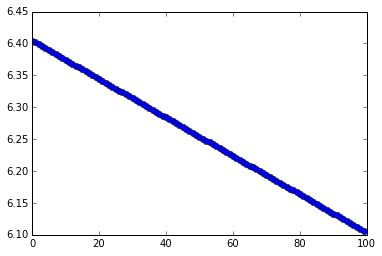

In [109]:
w, l1 = grad_descent(X, y_train, 0.001, 100)
plt.plot(range(100), l1, '-o')

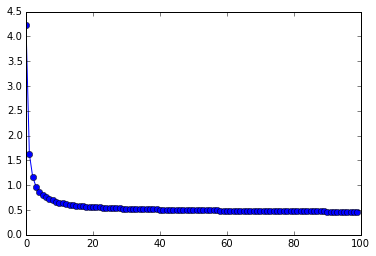

In [136]:
w, l1 = grad_descent(X, y_train, 1, 100)
plt.plot(range(100), l1, '-o')

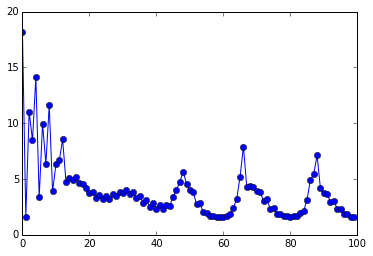

In [111]:
w, l1 = grad_descent(X, y_train, 10, 100)
plt.plot(range(100), l1, '-o')

Спуск с шагом 0.001 сходится очень медленно и долго, спуск с шагом 10 не сходится вовсе. Т.о. значение шага равное 1 оптимально.

In [137]:
roc_auc_score(y_test, make_pred(X_test, w))

0.84827474979538142

Теперь реализуйте стохастический градиентный спуск. Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В стохастическом градиентном спуске должно выполняться не более max_iter итераций.

In [33]:
def sgd(X, y, step_size, max_iter):
    list_func= list()
    w = np.random.uniform(-0.3, 0.3, size=X.shape[1])
    
    for i in range(max_iter):
        ind = np.random.randint(X.shape[0])
        w -= step_size * get_grad(w, X.iloc[i].reshape(1, -1), y[i]) / X.shape[0]
        list_func.append(get_func(w, X, y))
    
    return w, list_func

Подберите размер шага, при котором SGD будет сходиться. Нарисуйте график сходимости. Вычислите AUC-ROC на тестовой выборке.

In [41]:
w, l1 = sgd(X, y_train, 15, 5000)

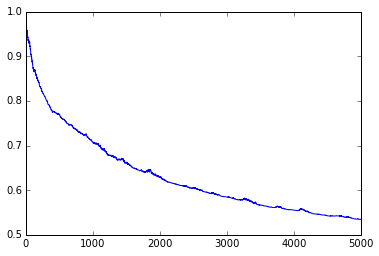

In [43]:
plt.plot(range(5000), l1, '-')

In [44]:
roc_auc_score(y_test, make_pred(X_test, w))

0.80184094699176789

А теперь самое сложное: заново сформируйте выборку с помощью transform_data, но теперь не масштабируйте вещественные признаки. Запустите на этой выборке градиентный спуск. Что вы наблюдаете? Удается ли достичь такого же качества, как и при использовании масштабирования?

In [8]:
def transform_data2(data, scaler, transformer, is_test):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    categorial_cols = list(set(data.columns).difference(set(numeric_cols)))
    data[numeric_cols] = data[numeric_cols].fillna(0)
    data[categorial_cols] = data[categorial_cols].fillna('nan')
    data[categorial_cols] = data[categorial_cols].applymap(lambda x: str(x))
    
    if is_test:
        temp = pd.DataFrame(transformer.transform(data[categorial_cols].T.to_dict().values()))
        indexes = list(map(lambda x: str(x), range(temp.shape[1])))
        data[indexes] = temp
    else:
        temp = pd.DataFrame(transformer.fit_transform(data[categorial_cols].T.to_dict().values()))
        indexes = list(map(lambda x: str(x), range(temp.shape[1])))
        data[indexes] = temp
    
    return data.drop(categorial_cols, axis=1), scaler, transformer



In [9]:
scaler = StandardScaler()
transformer = DictVectorizer(sparse=False)
X, scaler, transformer = transform_data2(data_train, scaler, transformer, False)
X_test, _, _ = transform_data2(data_test, scaler, transformer, True)

In [10]:
X['singular'] = 1
X_test['singular'] = 1
y_train = (y_train - 0.5) * 2
y_test = (y_test - 0.5) * 2

Сходимости не наблюдается даже при таком маленьком шаге

In [43]:
w, l1 = grad_descent(X, y_train, 0.000005, 50)

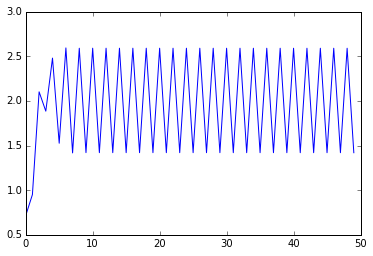

In [45]:
plt.plot(range(50), l1)

Если уменьшить шаг, функционал убывает очень медленно:

In [37]:
w, l1 = grad_descent(X, y_train, 0.000001, 500)

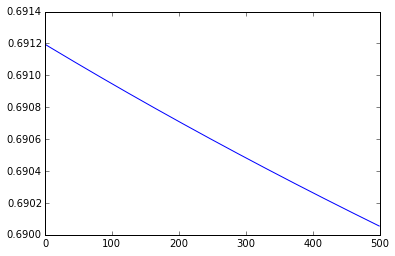

In [39]:
plt.plot(range(500), l1)

Маленькое значение площади под рок-кривой:

In [40]:
roc_auc_score(y_test, make_pred(X_test, w))

0.52102532592056217

Таким образом, можно сделать вывод, что масштабирование действительно очень полезно для линейных моделей.

## Часть 3. Линейная регрессия на простом примере

В этой части мы очень кратко разберемся с линейной регрессией и измерением качества ее прогнозов. Будем использовать датасет diabetes.

In [2]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
data = datasets.load_diabetes()
X, X_test, y, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

Обучите линейную регрессию с L2-регуляризатором, подобрав лучшее значение параметра регуляризации на тестовой выборке. Используйте MSE в качестве функционала качества. При каком значении этого параметра достигается наилучшее качество?

In [30]:
from sklearn.linear_model import Ridge
clf1 = Ridge()

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mea 

In [41]:
alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

for alpha in alpha_grid:
    clf1.alpha = alpha
    clf1.fit(X, y)
    y_pred = clf1.predict(X_test)
    print(alpha, mean_squared_error(y_test, y_pred))

0.001 3120.09020578
0.01 3107.38818648
0.1 3096.03015101
1.0 3399.40482339
10.0 4577.48210429
100.0 5210.22019186


При 0.1 качество 3096.035

Вычислите для лучшей из моделей RMSE и коэффициент детерминации (r2_score) на тестовой выборке. Что вы можете сказать о значении коэффицинта детерминации? Насколько данная модель близка к оптимальной?

In [42]:
clf1.alpha = 0.1

clf1.fit(X, y)
y_pred = clf1.predict(X_test)
print(mean_squared_error(y_test, y_pred) ** 0.5)

55.6419819113


In [44]:
clf1.score(X_test, y_test)

0.41702418482173664

$R^2$ меньше 0.5. Это говорит о том, что модель не очень хорошо работает. Она делека от оптимальной.